# 0. Setup

## 0.1. libaries

In [1]:
'''standard imports'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone

## 0.2. repo/data paths
**USABLE SYMBOLS:**

- `dirpath_repo` : str

(NOTE: You must hardcode this yourself)

In [2]:
dirpath_repo = r'C:\Users\Eris\Documents\sync_local\01_Research\wind'

## 0.3. `utils`
**USABLE FUNCTIONS:**
- `get_path` : -> str
- `print_dict` : -> print
- `printsep` : -> print
- `distance_km` : 2-tuple, 2-tuple -> float
- `unix_to_datetime` : int -> datetime

(usually this is it's own module, but we'll keep it simple for notebook drafting purposes)

In [3]:
'''utils'''

from typing import Union, List
from pathlib import Path

def get_path(*args: Union[str, List[str]]) -> str:
    """
    Join all arguments into a single path.
    
    Parameters:
        - Use 'current' to get the directory this file (the one calling this function) is in.
            - NOTE: things get tricky when using notebooks -- if you want to get the directory of the file that called the function that called `get_path` (?), use `Path(__file__).resolve().parent` (I'm not even sure if that's correct, honestly). It's usually easier/safer to implement this functionality yourself, I can't guarantee this will work.
        - Use '..' to navigate to the parent directory.
    
    Returns:
        `pathlib` object
            Absolute path by joining all input components and resolving
        
    Example:
        If you're running a script/notebook in `/src/main/`, you can get the path to `/src/data/foo.txt` with:
            `get_path('current', '..', 'data', 'foo.txt')`            
    """
    parts = []
    for arg in args:
        if isinstance(arg, List):
            parts.extend(arg)
        else:
            parts.append(arg)

    # Replace 'current' with the current working directory
    parts = [Path.cwd() if part == 'current' else Path(part) for part in parts]
    
    # Join all parts and resolve to get the absolute path
    
    # return str(Path(*parts).resolve())
    return Path(*parts).resolve()




def print_dict(d: dict, indent=0, format_pastable=False, condense_arrays=True) -> None:
    """
    DESCRIPTION:
    ------------
        Cleaner way to print a dictionary, with option to condense numpy arrays.

    PARAMETERS:
    ------------
        d : dict
            The dictionary to print.
        indent : int
            The current indentation level.
        format_pastable : bool
            (Default False) If True, will format the output so that it can be directly pasted into Python code as an assignment to a variable. 
        condense_arrays : bool
            (Default True) If True, condenses numpy arrays into a shape descriptor rather than printing each element. 
    """
    for key, value in d.items():
        spacing = '\t' * indent
        key_repr = f"'{key}'" if isinstance(key, str) else key
        if isinstance(value, dict):
            print(f"{spacing}{key_repr}")
            print_dict(value, indent+1, format_pastable, condense_arrays)
        elif isinstance(value, np.ndarray) and condense_arrays:
            print(f"{spacing}{key_repr}")
            print(f"{spacing}\t<np.ndarray, shape={value.shape}>")
        elif format_pastable:
            value_repr = f"'{value}'" if isinstance(value, str) else value
            print(f"{spacing}{key_repr}: {value_repr!r},")
        else:
            value_repr = f"'{value}'" if isinstance(value, str) else value
            print(f"{spacing}{key_repr}")
            print(f"{spacing}\t{value_repr}")



def printsep(n=100):
    print()
    print('-' * n)
    print()




def convert_dt2utc(input_datetime):
    """
    Check if the provided datetime object has timezone information.
    - If it does not have timezone information, set the timezone to UTC.
    - If it does have timezone information, convert it to UTC if it's not already in UTC.
    """
    # Check if the datetime object has timezone information
    if input_datetime.tzinfo is None or input_datetime.tzinfo.utcoffset(input_datetime) is None:
        # Set the timezone to UTC
        return input_datetime.replace(tzinfo=timezone.utc)
    else:
        # Convert the datetime to UTC
        return input_datetime.astimezone(timezone.utc)





def get_size(obj):
    '''Recursively find size of objects in bytes'''
    import sys
    if isinstance(obj, dict):
        return sum((get_size(v) for v in obj.values())) + sum((get_size(k) for k in obj.keys())) + sys.getsizeof(obj)
    elif isinstance(obj, list) or isinstance(obj, tuple) or isinstance(obj, set):
        return sum((get_size(i) for i in obj)) + sys.getsizeof(obj)
    elif isinstance(obj, np.ndarray):
        return obj.nbytes + sys.getsizeof(obj)
    else:
        return sys.getsizeof(obj)       




import cartopy.geodesic as gd
def distance_btwn_points_km(p1, p2):
    x, y, _ = gd.Geodesic().inverse(p1, p2)[0]
    return np.linalg.norm([x,y]) / 1.e3




def unix_to_datetime(unix_time_ms):
    '''Function to convert Unix timestamp (milliseconds) to a readable date'''
    return datetime.fromtimestamp(unix_time_ms / 1000, timezone.utc)



tab = '\t'

## 0.4. `owf_metadata`

**USABLE SYMBOLS:**
- `owf_metadata` : dict
    - We create the dict `owf_metadata`, whose KEYS are wind farm name, and VALUES are are fields described below:

**Description:**
- I made a CSV called owf_metadata.csv (available online [here](https://drive.google.com/drive/folders/1t4UKE1Xo6-_OaTlvJFUHIhXDvVkI99jU?usp=sharing)). For each wind farm, you have:
    - `name` (str) : 
        - name of wind farm (e.g. 'Hornsea Project One')
    - `lon`, `lat` (float) : 
        - longitude/latitude of the wind farm (approximate center)
            - source: wikipedia
    - `num_turbines` (int) : 
        - number of turbines in this wind farm
            - source: wikipedia
    - `capacity_mw` (float) : 
        - maximum amount of energy that can be produced in ideal conditions by the entire wind farm (in MW)
            - source: wikipedia
    - `start_operation_APPROX` (str / datetime) : 
        - approximate date when wind farm started operating at full capacity (warning: this is a very loose estimation based on random online sources)
            - source: manually inputted
        - note: in the dict this is converted to `datetime` object in place
    - `lon_left`, `lon_right`, `lat_bottom`, `lat_top` (float) : 
        - defines a bounding box around all turbines in the wind farm
            - source: manually inputted

In [4]:
'''
Metadata on various wind farms (coords, capacity, etc.)
    https://drive.google.com/drive/folders/1t4UKE1Xo6-_OaTlvJFUHIhXDvVkI99jU?usp=sharing
'''

owf_metadata = pd.read_csv(
    get_path(dirpath_repo, 'data', '1_raw', 'owf_metadata', 'owf_metadata.csv')
)


## formatting
owf_metadata['start_operation_APPROX'] = pd.to_datetime(owf_metadata['start_operation_APPROX'], format='%Y-%m-%d')
owf_metadata = owf_metadata.to_dict('index')
owf_metadata = {v['name']: v for k, v in owf_metadata.items()}

print_dict(owf_metadata)

'Hornsea Project One'
	'name'
		'Hornsea Project One'
	'lon'
		1.791111
	'lat'
		53.885
	'num_turbines'
		174
	'capacity_mw'
		1218.0
	'start_operation_APPROX'
		2019-02-01 00:00:00
	'lon_left'
		1.64
	'lon_right'
		2.25
	'lat_bottom'
		53.82
	'lat_top'
		53.98
'Horns Rev 3'
	'name'
		'Horns Rev 3'
	'lon'
		7.669167
	'lat'
		55.696944
	'num_turbines'
		49
	'capacity_mw'
		407.0
	'start_operation_APPROX'
		2019-08-22 00:00:00
	'lon_left'
		nan
	'lon_right'
		nan
	'lat_bottom'
		nan
	'lat_top'
		nan
'Horns Rev 1'
	'name'
		'Horns Rev 1'
	'lon'
		7.9833
	'lat'
		55.5333
	'num_turbines'
		80
	'capacity_mw'
		160.0
	'start_operation_APPROX'
		2002-12-11 00:00:00
	'lon_left'
		nan
	'lon_right'
		nan
	'lat_bottom'
		nan
	'lat_top'
		nan
'Anholt'
	'name'
		'Anholt'
	'lon'
		11.21
	'lat'
		56.6
	'num_turbines'
		111
	'capacity_mw'
		nan
	'start_operation_APPROX'
		2013-09-04 00:00:00
	'lon_left'
		11.138
	'lon_right'
		11.333
	'lat_bottom'
		56.498
	'lat_top'
		56.712


## 0.5. `owt_locs`


**USABLE SYMBOLS:**
- `get_owt_locs`: fn -> numpy.ndarray, shape (N, 2), float
    - Accessor function for `owt_locs` dataframe (loaded from the DeepOWT dataset). 
    - Recommended to use this instead of directly accessing `owt_locs`, for convenience. 
-  `periods` : list(str)
    - Sorted list of periods (quarters) with data from DeepOWT.
-  `periods_dt` : list(datetime)
    - Same as `periods`, but in datetime format.

Extra:
- `owt_locs` : pandas.DataFrame
    - pandas.DataFrame where each row represents a turbine on the planet, and each column represents its operational status in a given quarter.
    - Recommended to use `get_owt_locs` instead of directly accessing `owt_locs`, for convenience. 

**Description of DeepOWT dataset (loaded into`owt_locs`):**
- Each column TITLE is a quarter:
    - start: 'Y2016Q3'
    - end: 'Y2021Q2'
    - (total 20 periods)
- Each column VALUE is an int representing the operational status of a turbine:
    - 0 = open sea
    - 1 = under construction
    - 2 = offshore wind turbine
    - 3 = offshore wind farm substation

In [5]:
'''Turbine coordinates'''

fpath_owts = get_path(dirpath_repo, 'data', '1_raw', 'owf_metadata', 'DeepOWT.geojson')

'''
[From Zenodo page https://zenodo.org/record/5933967, also in references.txt]:
    Mapping of integer values used in the dataset to semantic classes [e.g. "Y2016Q3"]

    INTEGER   |  SEMANTIC LABEL                 |  ABBREVIATION
    0         |  open sea                       |  sea
    1         |  under construction             |  const
    2         |  offshore wind turbine          |  owt
    3         |  offshore wind farm substation  |  sub
'''

## for some reason, the native geopandas read_file() function is disgustingly slow by a factor of 10-50x
## instead, we opt to manually load/format the json ourselves. this requires a bit of wrangling, but ultimately possible bc the geopandas geometry point objects are simply just 2-tuples

# import geopandas as gpd
# dat_owts = gpd.read_file(fpath_owts)


import json
with open(fpath_owts, 'r') as f:
    owt_locs = json.load(f)
owt_locs = owt_locs['features'] # this gives us a list of dictionaries, now we flatten the inner dictionaries

def transform_dict(dic):
    properties = dic.get('properties', {})
    coordinates = dic.get('geometry', {}).get('coordinates', [])
    new_dic = properties
    new_dic['coordinates'] = coordinates
    return new_dic
owt_locs = [transform_dict(dic) for dic in owt_locs]

owt_locs = pd.DataFrame(owt_locs)

# owt_locs

In [6]:
'''print options for periods'''

periods = owt_locs.keys().values.tolist()
periods.remove('coordinates')
periods.sort()

print('Period options:')
for period in periods:
    print(f"'{period}'")

Period options:
'Y2016Q3'
'Y2016Q4'
'Y2017Q1'
'Y2017Q2'
'Y2017Q3'
'Y2017Q4'
'Y2018Q1'
'Y2018Q2'
'Y2018Q3'
'Y2018Q4'
'Y2019Q1'
'Y2019Q2'
'Y2019Q3'
'Y2019Q4'
'Y2020Q1'
'Y2020Q2'
'Y2020Q3'
'Y2020Q4'
'Y2021Q1'
'Y2021Q2'


In [7]:
def yq2dt(year_quarter_str):
    '''Convert a 'year-quarter' string (e.g. 'Y2019Q1') to a datetime object. Note that this returns the first day of the quarter, even though the input is technically a range of dates.'''
    # Extract year and quarter
    year = int(year_quarter_str[1:5])
    quarter = int(year_quarter_str[-1])
    # Map quarter to the beginning month
    month = (quarter - 1) * 3 + 1
    # Create datetime object for the first day of the corresponding month
    return datetime(year, month, 1, tzinfo=timezone.utc)


periods_dt = [yq2dt(period) for period in periods]






def dt2yq(dt, suppress_warning=False):

    dt = convert_dt2utc(dt)

    if dt < periods_dt[0]:
        if not suppress_warning:
            print(f'WARNING: The inputted date {dt.strftime("%Y-%m-%d")} is earlier than DeepOWT\'s earliest period. Defaulting to closest data ({periods[0]}). Use `suppress_warning=True` to suppress this message.')
    
        return periods[0]
    
    elif dt > periods_dt[-1]:
        if not suppress_warning:
            print(f'WARNING: The inputted date {dt.strftime("%Y-%m-%d")} is later than DeepOWT\'s latest period. Defaulting to closest data ({periods[-1]}). Use `suppress_warning=True` to suppress this message.')
    
        return periods[-1]
    
    else:
        period = None
        for i, val in enumerate(periods_dt):
            if dt < val:
                period = periods[i-1]
                break
        return period

In [8]:
import bisect

def get_owt_locs(
    period = 'Y2021Q2', 
    status = 'operational', 
    lon_bounds = (-180,180), 
    lat_bounds = (-90,90), 
    suppress_warning = False,
):
    """
    DESCRIPTION:
    ------------
        Accessor function for DeepOWT dataset. Get coordinates of turbines in a specific region / period.
        Requires `owt_locs`, `periods`, and `periods_dt` defined in global scope. 
    
    
    PARAMETERS:
    ------------
        period : str or datetime
            Period of interest. Can either be a string in the format 'Y2019Q1' or a datetime object. Range is 'Y2016Q3' to 'Y2021Q2' with no gaps (i.e 20 options). 
            Default is most recent: 'Y2021Q2'.

        status : int or str
            Select operational status of turbine. Options are:
                - 0 or 'open sea'
                - 1 or 'under construction'
                - 2 or 'operational'
                - 3 or 'substation' (referring to offshore wind farm substation)
            Default is operational turbines (2).

        lon_bounds, lat_bounds : 2-tuple of floats
            Bounding box for visualization. Longitude in range [-180, 180], latitude in range [-90, 90].
            Default entire map.


    RETURN:
    ------------
        numpy.ndarray, shape (N, 2), float
            Array of turbine coordinates, where N is number of turbines, and each row is a (lon, lat) pair.

            
    REFERENCES:
    ------------
        [see 'docs/references.txt' for more information...]

        Coordinates of all offshore wind turbines:
            - Zenodo dataset:
                > Hoeser, Thorsten, & Kuenzer, Claudia. (2022). DeepOWT: A global offshore wind turbine data set [Data set]. In Earth System Science Data (1.21.2, Vol. 14, pp. 4251–4270). Zenodo. https://doi.org/10.5281/zenodo.5933967
            - Original publication:
                > Hoeser, T., Feuerstein, S., & Kuenzer, C. (2022). DeepOWT: A global offshore wind turbine data set derived with deep learning from sentinel-1 data. Earth System Science Data, 14(9), 4251–4270. https://doi.org/10.5194/essd-14-4251-2022 
    """

    '''ARG HANDLING'''

    ## check coordinate bounds
    if not all(-180 <= lon <= 180 for lon in lon_bounds):
        raise ValueError(f'Longitude bounds {lon_bounds} are not in range [-180, 180].')
    if not all(-180 <= lat <= 180 for lat in lat_bounds):
        raise ValueError(f'Latitude bounds {lat_bounds} are not in range [-90, 90].')
    
    ## if period is datetime, convert to string
    if isinstance(period, datetime):
        period = dt2yq(period, suppress_warning=suppress_warning)
        # if period < periods_dt[0]:
        #     raise ValueError(f'The inputted date {period.strftime("%Y-%m-%d")} is earlier than DeepOWT\'s first period ({periods_dt[0].strftime("%Y-%m-%d")}).')
        # elif period > periods_dt[-1]:
        #     period = periods[-1]
        #     if not suppress_warning:
        #         print(f'WARNING: the inputted date is later than DeepOWT\'s last period. Defaulting to most recent period {period}. Use `suppress_warning=True` to suppress this message.')
        # else:
        #     for i, val in enumerate(periods_dt):
        #         if period < val:
        #             period = periods[i-1]
        #             break

    if period not in periods:
        raise ValueError(f'Invalid period {period}. Valid options are {periods}.')


    ## if status is string, convert to int code
    statuses = ['open sea', 'under construction', 'operational', 'substation']

    if isinstance(status, int) and not(0<=status<=3):
        raise ValueError(f"Invalid status '{status}'. Valid options are {statuses} or 0-3.")
    elif isinstance(status, str):
        if status not in statuses:
            raise ValueError(f"Invalid status '{status}'. Valid options are {statuses} or 0-3.")
        status = statuses.index(status)




    '''GET TURBINE COORDINATES'''
        

    '''step 1/2: find turbines operational in the given period'''

    ## limit database to turbines which were operational during the specified period
    owt_locs_thisPeriod = owt_locs[owt_locs[period] == status] 
    ## convert to Nx2 numpy array of (lon,lat)
    owt_locs_thisPeriod = np.array(owt_locs_thisPeriod['coordinates'].tolist()) 



    '''step 2/2: find turbines within the chosen boundaries'''

    bounded_indices = np.where(
        (lon_bounds[0] <= owt_locs_thisPeriod[:,0]                 ) &
        (                 owt_locs_thisPeriod[:,0] <= lon_bounds[1]) &
        (lat_bounds[0] <= owt_locs_thisPeriod[:,1]                 ) &
        (                 owt_locs_thisPeriod[:,1] <= lat_bounds[1])
    )
    owt_locs_thisPeriod = owt_locs_thisPeriod[bounded_indices]


    return owt_locs_thisPeriod

## 0.6. Choose a Wind Farm and Add Turbine Coordinates (i.e. combine `owf_metadata` and `owt_locs`)

**USABLE SYMBOLS:**
- `this_owf` : dict
    - Identical to a sub-dictionary of `owf_metadata`, but with the addition of a 'turbine_coords' key, which itself is a dictionary where keys are year-quarters (e.g. 'Y2020Q4') and values are numpy.ndarrays of shape (N,2) where N is the number of turbines in the wind farm, and the 2 columns are longitude and latitude of each turbine.

**Note:**
- The old method of manually filtering turbine locations by farm/period is [here](https://gist.github.com/Humboldt-Penguin/201661f003f991cb40ae4456dbdd5ccd).


Depracated symbol:
- `owt_locs_thisPeriod` : numpy.ndarray
    - Nx2 array of turbine locations (lon,lat) for a given period

In [9]:
print(f'Wind farm options:')
for name in owf_metadata.keys():
    print(f"'{name}'")

Wind farm options:
'Hornsea Project One'
'Horns Rev 3'
'Horns Rev 1'
'Anholt'


In [10]:
"""build `this_owf` by compositing `owf_metadata` and `owt_locs`"""

name = 'Hornsea Project One'
# name = 'Anholt'


## NOTE: end user input


'''[1/2]: windfarm metadata from `owf_metadata`'''

this_owf = owf_metadata[name]



'''[2/2]: add turbine coords for each period'''

this_owf['lon_bounds'] = (this_owf['lon_left'], this_owf['lon_right'])
this_owf['lat_bounds'] = (this_owf['lat_bottom'], this_owf['lat_top'])

this_owf['turbine_coords'] = {}
for this_period_str in periods:
    this_owf['turbine_coords'][this_period_str] = get_owt_locs(period=this_period_str, status='operational', lon_bounds=this_owf['lon_bounds'], lat_bounds=this_owf['lat_bounds'])

print_dict(this_owf)

'name'
	'Hornsea Project One'
'lon'
	1.791111
'lat'
	53.885
'num_turbines'
	174
'capacity_mw'
	1218.0
'start_operation_APPROX'
	2019-02-01 00:00:00
'lon_left'
	1.64
'lon_right'
	2.25
'lat_bottom'
	53.82
'lat_top'
	53.98
'lon_bounds'
	(1.64, 2.25)
'lat_bounds'
	(53.82, 53.98)
'turbine_coords'
	'Y2016Q3'
		<np.ndarray, shape=(0, 2)>
	'Y2016Q4'
		<np.ndarray, shape=(0, 2)>
	'Y2017Q1'
		<np.ndarray, shape=(0, 2)>
	'Y2017Q2'
		<np.ndarray, shape=(0, 2)>
	'Y2017Q3'
		<np.ndarray, shape=(0, 2)>
	'Y2017Q4'
		<np.ndarray, shape=(0, 2)>
	'Y2018Q1'
		<np.ndarray, shape=(0, 2)>
	'Y2018Q2'
		<np.ndarray, shape=(4, 2)>
	'Y2018Q3'
		<np.ndarray, shape=(4, 2)>
	'Y2018Q4'
		<np.ndarray, shape=(4, 2)>
	'Y2019Q1'
		<np.ndarray, shape=(5, 2)>
	'Y2019Q2'
		<np.ndarray, shape=(39, 2)>
	'Y2019Q3'
		<np.ndarray, shape=(100, 2)>
	'Y2019Q4'
		<np.ndarray, shape=(171, 2)>
	'Y2020Q1'
		<np.ndarray, shape=(174, 2)>
	'Y2020Q2'
		<np.ndarray, shape=(174, 2)>
	'Y2020Q3'
		<np.ndarray, shape=(174, 2)>
	'Y2020Q4'
		<np

In [11]:
dict_size = get_size(this_owf)
print(f"Dictionary for this OWF is approximately {dict_size} bytes in RAM.")

Dictionary for this OWF is approximately 49560 bytes in RAM.


---
# Summary of usable functions/variables (0. Setup)

```
- helper functions
    - `get_path`         : (fn) *args -> str
    - `print_dict`       : (fn) -> (print)
    - `printsep`         : (fn) -> (print)
    - `yq2dt`            : (fn) str -> datetime
    - `distance_km`      : (fn) 2-tuple, 2-tuple -> float
    - `unix_to_datetime` : (fn) int -> datetime
- system
    - `dirpath_repo`     : str
- data
    - `this_owf`         : dict
        - `periods`      : list(str)
        - `periods_dt`   : list(datetime)
    - `get_owt_locs`     : (fn) *args -> numpy.ndarray, shape (N, 2), float
```

<!---
| CATEGORY | VAR_NAME | TYPE |
| --- | --- | --- |
| helper functions | `get_path` | fn -> str |
| ^ | `print_dict` | fn -> print |
| ^ | `printsep` | fn -> print |
| system | `dirpath_repo` | str |
| data | `this_owf` | dict |
| ^ | `owt_locs` | pandas.DataFrame |
-->

--- 
# 1. Query EE, Load to DF, Downsample, Load to Array

## 1.0. Setup

In [12]:
'''earth engine'''
import ee
# ee.Authenticate() ## Trigger the authentication flow -- Note: This must be run the first time you use EE. After the first time, it saves an access token in '~\.config\earthengine'. However this may expire at some point, so uncomment and rerun if necessary. 
ee.Initialize()

import geemap

import IPython.display as disp


'''geographic plotting'''
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# from dateutil import parser

---
## 1.1. Query EE

**USABLE SYMBOLS:**
- `s1_df`

In [13]:
'''define AOI'''

desired_time = datetime(2020, 1, 1, tzinfo=timezone.utc)
# desired_time = datetime(2023, 1, 1)


## one turbine
# choice_turbine = this_owf['turbine_coords'][dt2yq(desired_time)][50]
# padding_degrees = 0.025
# aoi_lon_bounds = (choice_turbine[0] - padding_degrees, choice_turbine[0] + padding_degrees)
# aoi_lat_bounds = (choice_turbine[1] - padding_degrees, choice_turbine[1] + padding_degrees)


# ## full farm
padding_degrees = 0.2
aoi_lon_bounds = (this_owf['lon_left'] - padding_degrees, this_owf['lon_right'] + padding_degrees)
aoi_lat_bounds = (this_owf['lat_bottom'] - padding_degrees, this_owf['lat_top'] + padding_degrees)




aoi = ee.Geometry.Rectangle(
    coords = [aoi_lon_bounds[0], aoi_lat_bounds[0], aoi_lon_bounds[1], aoi_lat_bounds[1]]
)






'''call EE for S1 collection in AOI'''

# NOTE: properties that can be filtered can be found here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD#image-properties
s1_collection = (
    ee.ImageCollection('COPERNICUS/S1_GRD')           # Note: this is units of dB // use 'COPERNICUS/S1_GRD_FLOAT' for float intensities.
        # .filterDate( ee.Date(desired_time), ee.Date(desired_time).advance(1, 'month') )
        .filterBounds(aoi)
        .filter(ee.Filter.contains('.geo', aoi))
        # .filter(ee.Filter.eq('instrumentMode', 'EW')) # this is the highest resolution we can access
        # .filter(ee.Filter.eq('resolution', 'H'))      # effectively redundant with IW, for some reason
        .sort('system:time_start')
)

s1_collection_size = s1_collection.size().getInfo()






'''load S1 collection into dataframe of images'''

columns = ['system:id', 'system:time_start', 'instrumentMode', 'resolution', 'system:bands', 'resolution_meters', 'relativeOrbitNumber_start', 'orbitProperties_pass']

s1_dict = {}
for col in columns:
    s1_dict[col] = s1_collection.aggregate_array(col).getInfo()
    # key(string): value(list)

s1_dict['system:time_start'] = [unix_to_datetime(t) for t in s1_dict['system:time_start']]
s1_dict['system:bands'] = [sorted(d.keys()) for d in s1_dict['system:bands']]

s1_df = pd.DataFrame.from_dict(s1_dict)


## peek dataframe:
print(f'Found {s1_df.shape[0]} images for given instrument/space/time constraints.')
print()
print(f'counts for {s1_df["instrumentMode"].value_counts()}')
print()
s1_df.head()

Found 640 images for given instrument/space/time constraints.

counts for instrumentMode
IW    628
EW     12
Name: count, dtype: int64



system:id  \
0  COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20141111T06...   
1  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SDV_20141114T17...   
2  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20141217T06...   
3  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSV_20141229T06...   
4  COPERNICUS/S1_GRD/S1A_EW_GRDM_1SDH_20150101T17...   

                 system:time_start instrumentMode resolution     system:bands  \
0 2014-11-11 06:05:39.890000+00:00             IW          H  [VH, VV, angle]   
1 2014-11-14 17:41:25.610000+00:00             EW          M  [VH, VV, angle]   
2 2014-12-17 06:05:33.490000+00:00             EW          M      [HH, angle]   
3 2014-12-29 06:05:32.930000+00:00             EW          M      [VV, angle]   
4 2015-01-01 17:41:24.340000+00:00             EW          M  [HH, HV, angle]   

   resolution_meters  relativeOrbitNumber_start orbitProperties_pass  
0                 10                          8           DESCENDING  
1                 40                         59            ASCENDING  
2                 40                          8           DESCENDING  
3                 40                          8           DESCENDING  
4                 40                         59            ASCENDING

---
## 1.2. Choose Image and Downsample

In [14]:
'''filter df'''
s1_df_filtered = s1_df[
    (s1_df['instrumentMode'] == 'IW') &
    (s1_df['system:time_start'] > desired_time) # & 
    # ('VV' in s1_df['system:bands'])
]





'''choose image'''
img_metadata = s1_df_filtered.iloc[28]

this_time = img_metadata['system:time_start']
print(f'{this_time = }')



'''load image'''

img = ee.Image(img_metadata['system:id'])

this_time = Timestamp('2020-04-01 06:06:09+0000', tz='UTC')


In [15]:
img

In [78]:
'''basic bounds for quick initial inspection (looking for wakes)'''

scaled_img = img

scaled_img = scaled_img.select('VV')
scaled_img = scaled_img.clip(aoi)

scaled_img = scaled_img.reproject(crs=scaled_img.projection(), scale=15)  # scale in meters


url = scaled_img.getThumbURL({'min': -25, 'max': 0})
# url = scaled_img.getThumbURL()
disp.Image(url=url, width=1000)

In [85]:
'''custom bounds for finalizing shape and resolution (preparing for conversion to numpy array)'''

print(f"{this_owf['lon_bounds'] = }")
print(f"{this_owf['lat_bounds'] = }")


aoi_lon_bounds = list(this_owf['lon_bounds'])
aoi_lat_bounds = list(this_owf['lat_bounds'])


# aoi_lon_bounds[0] -= 0.25
# aoi_lon_bounds[1] += 0.7

# aoi_lat_bounds[0] -= 0.15
# aoi_lat_bounds[1] += 0.15
aoi_lon_bounds[0] -= 0.7
aoi_lon_bounds[1] += 0.7

aoi_lat_bounds[0] -= 0.7
aoi_lat_bounds[1] += 0.7

print()
print(f'{aoi_lon_bounds = }')
print(f'{aoi_lat_bounds = }')

aoi_custom = ee.Geometry.Rectangle(
    coords = [aoi_lon_bounds[0], aoi_lat_bounds[0], aoi_lon_bounds[1], aoi_lat_bounds[1]],
    # proj = img.projection(),
    # evenOdd = False
)




'''scale and display'''

# SCALE_FACTOR = 147
SCALE_FACTOR = 50

scaled_img = img

scaled_img = scaled_img.select('VV')
scaled_img = scaled_img.clip(aoi_custom)

scaled_img = scaled_img.reproject(crs=scaled_img.projection(), scale=SCALE_FACTOR)  # scale in meters


url = scaled_img.getThumbURL({'min': -25, 'max': -10})#, 'palette': ['#440154', '#fde725']})
# url = scaled_img.getThumbURL()
disp.Image(url=url, width=1000)

this_owf['lon_bounds'] = (1.64, 2.25)
this_owf['lat_bounds'] = (53.82, 53.98)

aoi_lon_bounds = [0.94, 2.95]
aoi_lat_bounds = [53.12, 54.68]


In [79]:
'''custom bounds for finalizing shape and resolution (preparing for conversion to numpy array)'''

print(f"{this_owf['lon_bounds'] = }")
print(f"{this_owf['lat_bounds'] = }")


aoi_lon_bounds = list(this_owf['lon_bounds'])
aoi_lat_bounds = list(this_owf['lat_bounds'])


aoi_lon_bounds[0] -= 0.25
aoi_lon_bounds[1] += 0.7

aoi_lat_bounds[0] -= 0.15
aoi_lat_bounds[1] += 0.15

print()
print(f'{aoi_lon_bounds = }')
print(f'{aoi_lat_bounds = }')

aoi_custom = ee.Geometry.Rectangle(
    coords = [aoi_lon_bounds[0], aoi_lat_bounds[0], aoi_lon_bounds[1], aoi_lat_bounds[1]],
    # proj = img.projection(),
    # evenOdd = False
)




'''scale and display'''

SCALE_FACTOR = 147

scaled_img = img

scaled_img = scaled_img.select('VV')
scaled_img = scaled_img.clip(aoi_custom)

scaled_img = scaled_img.reproject(crs=scaled_img.projection(), scale=SCALE_FACTOR)  # scale in meters


url = scaled_img.getThumbURL({'min': -25, 'max': -10, 'palette': ['#440154', '#fde725']})
# url = scaled_img.getThumbURL()
disp.Image(url=url, height=700)

this_owf['lon_bounds'] = (1.64, 2.25)
this_owf['lat_bounds'] = (53.82, 53.98)

aoi_lon_bounds = [1.39, 2.95]
aoi_lat_bounds = [53.67, 54.129999999999995]


In [18]:
'''I was trying to write some code to count the number of pixels so I can manually calculate the min scale factor (to preserve the most resolution), but I realize I can just use try-except blocks in the later geemap numpy load thing, just optimized...?'''

# # Assuming you have an ee.Image object.
# image = scaled_img

# # Get the pixel count.
# pixel_count = image.reduceRegion(
#     reducer=ee.Reducer.count(),
#     geometry=aoi_custom,
#     scale=SCALE_FACTOR,  # Replace with the appropriate scale for your image.
#     maxPixels=1e9
# ).getInfo()

# # Assuming it's a single-band image, the pixel count will be under the band name.
# # band_name = image.bandNames().get(0).getInfo()  # Get the name of the first (and only) band.
# # number_of_pixels = pixel_count[band_name]
# number_of_pixels = pixel_count[chosen_band]

# number_of_pixels *= 1.08

# print(f"Number of pixels: {number_of_pixels:,}")
# print(f"Must be less than: {262144:,}")
# print()

# if number_of_pixels > 262144:
#     raise ValueError("The selected area is too large. Zoom in and try again.")
# print('All is good :)')


'I was trying to write some code to count the number of pixels so I can manually calculate the min scale factor (to preserve the most resolution), but I realize I can just use try-except blocks in the later geemap numpy load thing, just optimized...?'

---
## 1.3. Load Image to Array

In [19]:
'''choose SAR band'''

print(f"Available bands: {img_metadata['system:bands']}")

# chosen_band = img_metadata['system:bands'][0] # by default, choose the first (we previously sorted alphabetically, so this will never be 'angle')
chosen_band = 'VV'
print(f'Chosen band: {chosen_band}')



'''add lonlat bands with proper projection'''
og_projection = scaled_img.select(chosen_band).projection() # this must be the projection object, not just the standard name as a string, or else it fails to work for some reason
scaled_img = scaled_img.addBands(ee.Image.pixelLonLat())
scaled_img = scaled_img.setDefaultProjection(og_projection)

s1_dat = {
    'band': chosen_band, 
    'sar_db' : geemap.ee_to_numpy( scaled_img.select(chosen_band),  region=aoi_custom , default_value=999.0).squeeze(),
    'lon' : geemap.ee_to_numpy( scaled_img.select('longitude'),  region=aoi_custom , default_value=999.0).squeeze(),
    'lat' : geemap.ee_to_numpy( scaled_img.select('latitude') ,  region=aoi_custom , default_value=999.0).squeeze(),
}



def replace_999_with_nan(data_dict):
    """
    Iterate through a dictionary, and if a value is a numpy array,
    replace all values in that array that are equal to 999.0 with NaN.
    """
    for key, value in data_dict.items():
        if isinstance(value, np.ndarray):
            # Ensure the value is of a floating-point type to handle NaN
            data_dict[key] = value.astype(float)
            data_dict[key][value == 999.0] = np.nan
    return data_dict

s1_dat = replace_999_with_nan(s1_dat)

Available bands: ['VH', 'VV', 'angle']
Chosen band: VV


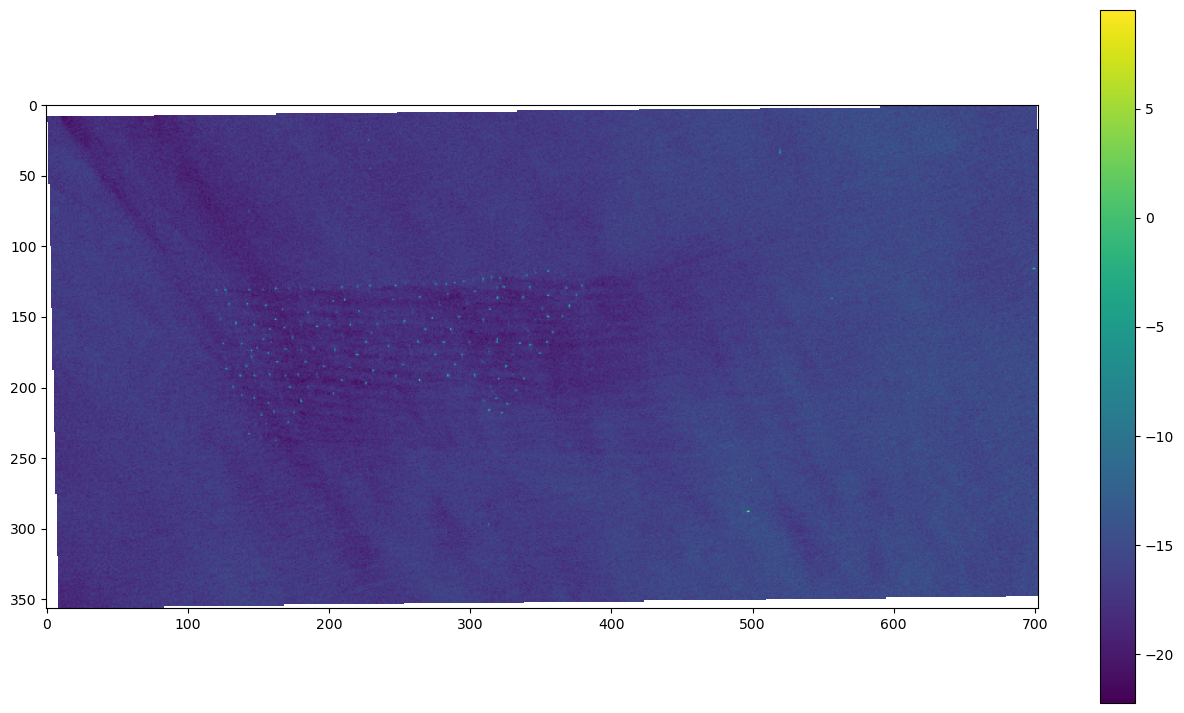

In [20]:
plt.figure(figsize=(16, 9))
plt.imshow(s1_dat['sar_db'])
plt.colorbar()
plt.show()

In [21]:
def db2float(dat):
    return 10**(dat/10)

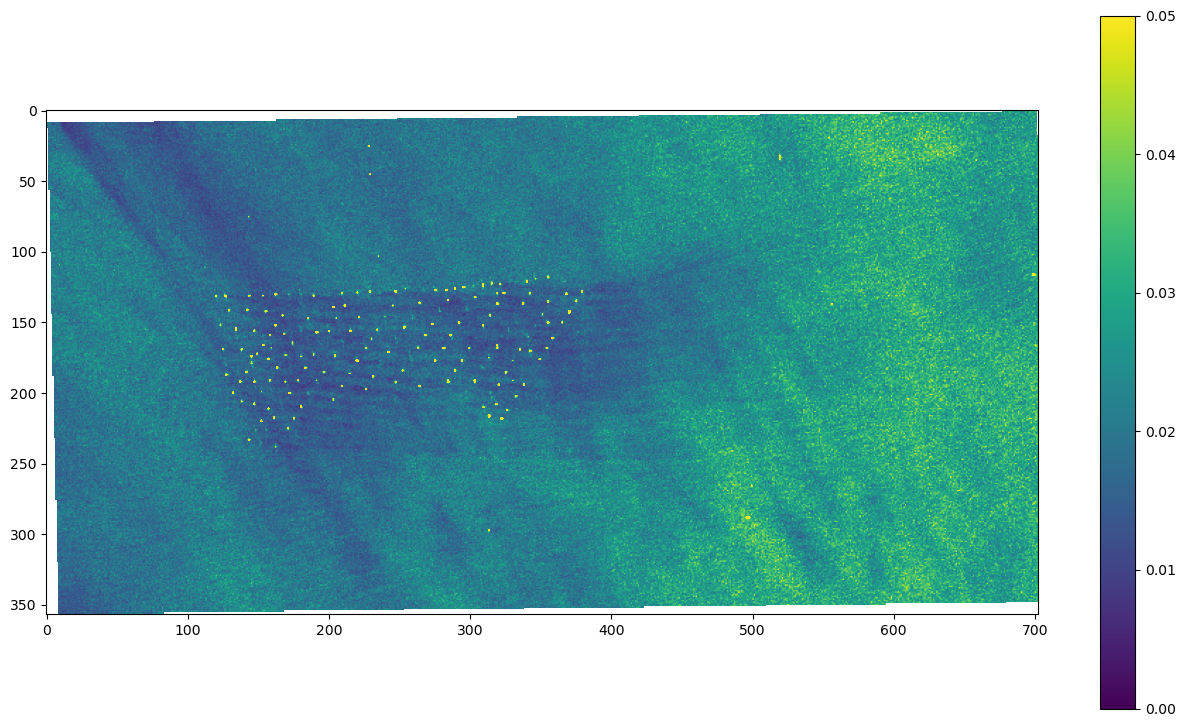

In [22]:
plt.figure(figsize=(16, 9))
plt.imshow(db2float(s1_dat['sar_db']), vmin=0, vmax=0.05)
plt.colorbar()
plt.show()

In [23]:
''' vvv take advantage of this to maybe start at a super lower resolution, get a few data points, then make a function that lets you know the closest you can go? lol idfk'''
print(f'num pixels: {np.prod(s1_dat['sar_db'].shape)}')

num pixels: 250971


---
## 1.5. Processing/smoothing sar data

In [24]:
from scipy.ndimage import median_filter

def despeckle_sar_data(sar_data, kernel_size=3):
    """
    Apply a median filter to despeckle SAR data.

    :param sar_data: A 2D numpy array representing SAR data.
    :param kernel_size: Size of the median filter kernel, defaults to 3.
    :return: Despeckled SAR data as a 2D numpy array.
    """
    despeckled_data = median_filter(sar_data, size=kernel_size)
    return despeckled_data



def mask_outliers(sar_data, threshold_factor=3):
    """
    Mask outliers in SAR data that may contain np.nan values. 
    Outliers are defined as values significantly higher than the mean, 
    indicating extremely bright spots like wind turbines.

    :param sar_data: A 2D numpy array representing SAR data, which may contain np.nan values.
    :param threshold_factor: Factor to determine the threshold for outliers, defaults to 3.
    :return: SAR data with outliers masked as np.nan.
    """
    valid_data = sar_data[~np.isnan(sar_data)]  # Exclude np.nan values from calculations
    mean = np.mean(valid_data)
    std_dev = np.std(valid_data)
    threshold = mean + threshold_factor * std_dev

    masked_data = np.where((sar_data > threshold) | np.isnan(sar_data), np.nan, sar_data)
    return masked_data




import cartopy.geodesic as gd

def mask_turbines(dat, lon, lat, turbine_coords, radius_m):
    """
    Mask out wind turbines in SAR data.

    :param dat: A 2D numpy array representing SAR data.
    :param lon: A 2D numpy array representing longitude values.
    :param lat: A 2D numpy array representing latitude values.
    :param turbine_coords: A list of (lon, lat) tuples representing the coordinates of wind turbines.
    :param radius_m: Radius in meters to mask around each turbine.
    :return: A 2D numpy array, identical to `dat` but with wind turbines masked out.
    """

    for lon_turb, lat_turb in turbine_coords:
        circle = gd.Geodesic().circle(lon_turb, lat_turb, radius=radius_m, n_samples=360)
        lon_left = np.min(circle[:,0])
        lon_right = np.max(circle[:,0])
        lat_bottom = np.min(circle[:,1])
        lat_top = np.max(circle[:,1])

        dat = np.where(
            (lon >= lon_left) & (lon <= lon_right) & (lat >= lat_bottom) & (lat <= lat_top),
            np.nan,
            dat
        )
    return dat


def mask_turbines_dirty(dat, lon, lat, turbine_coords, radius_degrees):
    """
    Mask out wind turbines in SAR data, quick and dirty method.

    :param dat: A 2D numpy array representing SAR data.
    :param lon: A 2D numpy array representing longitude values.
    :param lat: A 2D numpy array representing latitude values.
    :param turbine_coords: A list of (lon, lat) tuples representing the coordinates of wind turbines.
    :param radius_degrees: radius in degrees to mask out turbines.
    :return: A 2D numpy array, identical to `dat` but with wind turbines masked out.
    """

    for lon_turb, lat_turb in turbine_coords:
        lon_left = lon_turb - radius_degrees
        lon_right = lon_turb + radius_degrees
        lat_bottom = lat_turb - radius_degrees
        lat_top = lat_turb + radius_degrees

        dat = np.where(
            (lon >= lon_left) & (lon <= lon_right) & (lat >= lat_bottom) & (lat <= lat_top),
            np.nan,
            dat
        )
    return dat


In [25]:
'''init new entry'''
# s1_dat['sar_sm'] = s1_dat['sar_db']
s1_dat['sar_sm'] = db2float(s1_dat['sar_db'])
this_turbine_coords = this_owf['turbine_coords'][dt2yq(this_time)]


if (np.nanmin(s1_dat['sar_sm']) >= 0):
    units = '$[m^2]$'
else:
    units = '$[dB]$'

'''filter turbine radius'''
radius_m = 150
s1_dat['sar_sm'] = mask_turbines(s1_dat['sar_sm'], s1_dat['lon'], s1_dat['lat'], this_turbine_coords, radius_m=radius_m)
# sar_data = mask_turbines_dirty(sar_data, s1_dat['lon'], s1_dat['lat'], this_turbine_coords, radius_degrees=0.002)



'''filter outliers (weirdly slow? but it's necessary for random pixels here and there, which are usually just ships/anomalies)'''
s1_dat['sar_sm'] = mask_outliers(s1_dat['sar_sm'], threshold_factor=2)


'''median filter'''
kernel_size = 3
# apply_median_filter = False
apply_median_filter = True
if apply_median_filter:
    s1_dat['sar_sm'] = despeckle_sar_data(s1_dat['sar_sm'], kernel_size=kernel_size)
    
    ## need to remask turbines since median filter introduces new values based on nans
    s1_dat['sar_sm'] = mask_turbines(s1_dat['sar_sm'], s1_dat['lon'], s1_dat['lat'], this_turbine_coords, radius_m=radius_m)

---
## 1.6. Basic Plotting (proper geography)

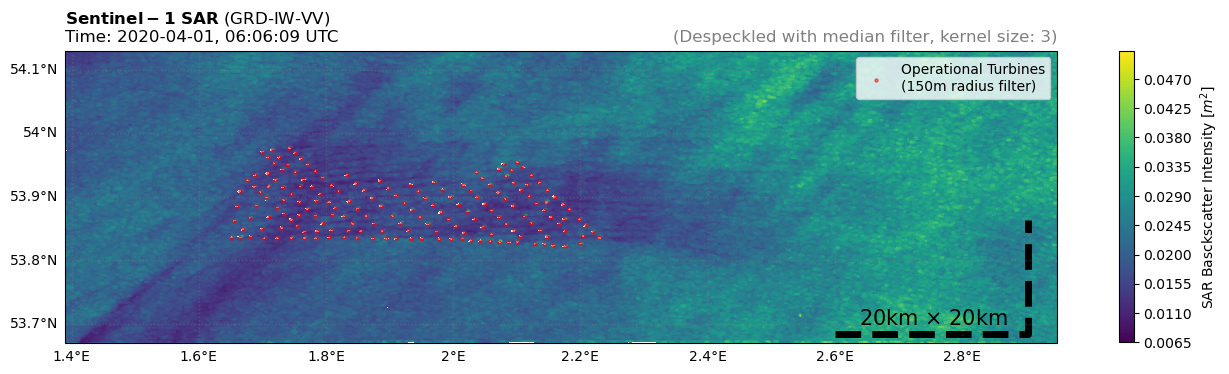

In [26]:
'''init plot'''
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection=ccrs.PlateCarree())



'''axes limits'''
ax.set_xlim(aoi_lon_bounds)
ax.set_ylim(aoi_lat_bounds)



'''layer 1: sar 2d data colored'''
# ax_sar_pcolormesh = ax.pcolormesh(
#     s1_dat['lon'], s1_dat['lat'], s1_dat['sar_db'][:-1,:-1],
#     shading='flat', # 'flat' means no interpolation
#     cmap='viridis',
#     alpha=0.8,
#     transform=ccrs.PlateCarree()
# )

# cbar = plt.colorbar(ax_sar_pcolormesh, shrink=0.42)
# cbar.set_label('SAR Backscatter $[dB]$')



ax_sar_contour = ax.contourf(
    s1_dat['lon'], s1_dat['lat'], s1_dat['sar_sm'],
    levels = 200,
    # vmax = -15,
    cmap = 'viridis',
    alpha = 1,
    transform = ccrs.PlateCarree()
)

cbar = plt.colorbar(ax_sar_contour, shrink=0.42)
# cbar = plt.colorbar(ax_sar_contour, shrink=0.7)


cbar.set_label(f'SAR Basckscatter Intensity {units}')






'''layer -2: turbine locs'''
ax_turbine_scatter = ax.scatter(
    x = this_turbine_coords[:,0],
    y = this_turbine_coords[:,1],
    # x = choice_turbine[0],
    # y = choice_turbine[1],
    transform = ccrs.PlateCarree(),
    # s = 1,
    s = 5,
    alpha=0.5,
    color = 'red', 
    label = f'Operational Turbines\n({radius_m}m radius filter)'
)

ax.legend(loc='upper right')





'''layer -1: coastlines'''
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='white', facecolor='white')) # white-out data on land masses
ax.coastlines(resolution='10m', linewidth=2, color='black') # draw coastlines






'''grid + ticks'''
ax_grid = ax.gridlines(
    transform=ccrs.PlateCarree(),
    draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle=':'
)

ax_grid.xformatter = LONGITUDE_FORMATTER
ax_grid.yformatter = LATITUDE_FORMATTER

ax_grid.top_labels = False
ax_grid.right_labels = False




'''scalebar'''

percent_spacing = 0.03
lon_bottom_right = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0]) * (1-percent_spacing)
lat_bottom_right = ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0]) * percent_spacing

km_scaling = 20
circle_1km = gd.Geodesic().circle(lon_bottom_right, lat_bottom_right, radius=km_scaling * 1.e3, n_samples=360)
lon_left = np.min(circle_1km[:,0])
lat_up = np.max(circle_1km[:,1])

x = np.array([lon_left, lon_bottom_right, lon_bottom_right])
y = np.array([lat_bottom_right, lat_bottom_right, lat_up])
plt.plot(
    x, y, 
    linewidth=5, 
    color='black', 
    linestyle='--',
    transform=ccrs.PlateCarree(),
)


percent_spacing = 0.05
lon_bottom_right = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0]) * (1-percent_spacing)
lat_bottom_right = ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0]) * percent_spacing
ax.text(
    lon_bottom_right, lat_bottom_right,
    s= str(km_scaling) + r'km $\times$ ' + str(km_scaling) + 'km',
    fontsize=15,
    color='black',
    transform=ccrs.PlateCarree(),
    ha='right', va='bottom',
)



'''titles'''

title_1 = []
title_1.append(rf"$\bf{{Sentinel-1\ SAR}}$ (GRD-IW-{chosen_band})")
title_1.append(f"Time: {this_time.strftime('%Y-%m-%d, %H:%M:%S')} UTC")

title_1 = '\n'.join(title_1)
plt.title(title_1, loc='left') #, loc='left', fontsize=15)


if (apply_median_filter and kernel_size > 1):
    plt.title(f"(Despeckled with median filter, kernel size: {kernel_size})", loc='right', color='grey')

plt.show()

Various values for median filtering: https://docs.google.com/presentation/d/1N5tpiCmJQiAHs2vi3bJRCcRO7eqk5tJ8P_DorfdYRtY/edit?usp=sharing

Best value is `kernel_size=3`?

---
## 1.4. Cross-sections

In [27]:
def line_sampler(quadrilateral, num_lines=100, points_per_line=100):
    """
    Samples equidistant lines across a quadrilateral.

    :param quadrilateral: A list of four points (where each point is a 2-tuple) defining the quadrilateral. The first two points represent the first line from start to stop, and the last two points represent the last line from start to stop. Lines will be generated equidistantly from the first line to the second line.
    :param num_lines: Number of lines to draw from the left to the right edge.
    :param points_per_line: Number of points to sample on each line.
    :return: NumPy array of shape (num_lines, points_per_line, 2) containing the sampled points.
    """
    P3, P4, P2, P1 = quadrilateral
    # Create arrays for interpolation
    left_edge = np.linspace(P1, P4, num_lines)[:, np.newaxis, :]
    right_edge = np.linspace(P2, P3, num_lines)[:, np.newaxis, :]
    points = np.linspace(0, 1, points_per_line)

    # Reshape points for broadcasting
    points = points.reshape((1, points_per_line, 1))

    # Broadcasting to create grid of points
    lines = left_edge + points * (right_edge - left_edge)
    return lines

In [28]:
points = np.array([
    [1.45, 53.91],
    [2.8, 53.91],
    [1.45, 53.84],
    [2.8, 53.84],
])

line_coords = line_sampler(points, num_lines=10, points_per_line=50)

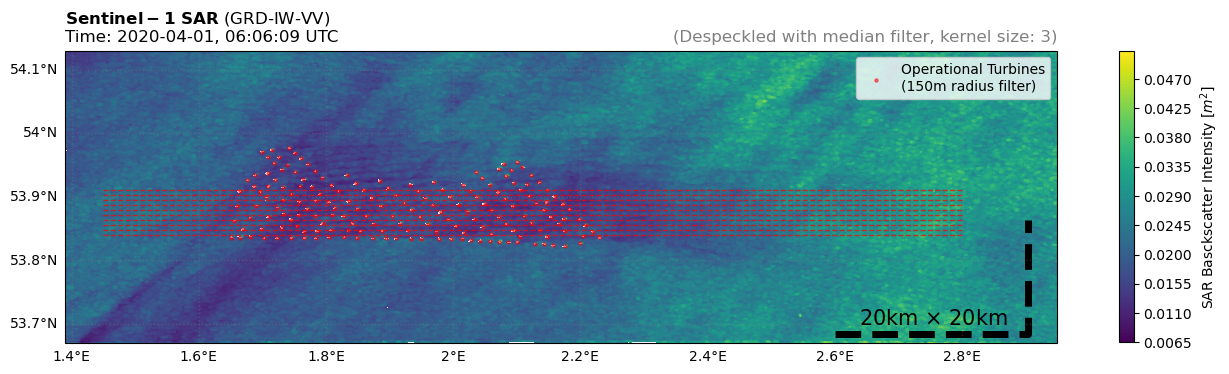

In [29]:
'''init plot'''
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection=ccrs.PlateCarree())



'''axes limits'''
ax.set_xlim(aoi_lon_bounds)
ax.set_ylim(aoi_lat_bounds)



'''layer 1: sar 2d data colored'''
# ax_sar_pcolormesh = ax.pcolormesh(
#     s1_dat['lon'], s1_dat['lat'], s1_dat['sar_db'][:-1,:-1],
#     shading='flat', # 'flat' means no interpolation
#     cmap='viridis',
#     alpha=0.8,
#     transform=ccrs.PlateCarree()
# )

# cbar = plt.colorbar(ax_sar_pcolormesh, shrink=0.42)
# cbar.set_label('SAR Backscatter $[dB]$')



ax_sar_contour = ax.contourf(
    s1_dat['lon'], s1_dat['lat'], s1_dat['sar_sm'],
    levels = 200,
    # vmax = -15,
    cmap = 'viridis',
    alpha = 1,
    transform = ccrs.PlateCarree()
)

cbar = plt.colorbar(ax_sar_contour, shrink=0.42)
# cbar = plt.colorbar(ax_sar_contour, shrink=0.7)


cbar.set_label(f'SAR Basckscatter Intensity {units}')






'''layer -2: turbine locs'''
ax_turbine_scatter = ax.scatter(
    x = this_turbine_coords[:,0],
    y = this_turbine_coords[:,1],
    # x = choice_turbine[0],
    # y = choice_turbine[1],
    transform = ccrs.PlateCarree(),
    # s = 1,
    s = 5,
    alpha=0.5,
    color = 'red', 
    label = f'Operational Turbines\n({radius_m}m radius filter)'
)

ax.legend(loc='upper right')





'''layer -1: coastlines'''
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='white', facecolor='white')) # white-out data on land masses
ax.coastlines(resolution='10m', linewidth=2, color='black') # draw coastlines






'''grid + ticks'''
ax_grid = ax.gridlines(
    transform=ccrs.PlateCarree(),
    draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle=':'
)

ax_grid.xformatter = LONGITUDE_FORMATTER
ax_grid.yformatter = LATITUDE_FORMATTER

ax_grid.top_labels = False
ax_grid.right_labels = False




'''scalebar'''

percent_spacing = 0.03
lon_bottom_right = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0]) * (1-percent_spacing)
lat_bottom_right = ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0]) * percent_spacing

km_scaling = 20
circle_1km = gd.Geodesic().circle(lon_bottom_right, lat_bottom_right, radius=km_scaling * 1.e3, n_samples=360)
lon_left = np.min(circle_1km[:,0])
lat_up = np.max(circle_1km[:,1])

x = np.array([lon_left, lon_bottom_right, lon_bottom_right])
y = np.array([lat_bottom_right, lat_bottom_right, lat_up])
plt.plot(
    x, y, 
    linewidth=5, 
    color='black', 
    linestyle='--',
    transform=ccrs.PlateCarree(),
)


percent_spacing = 0.05
lon_bottom_right = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0]) * (1-percent_spacing)
lat_bottom_right = ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0]) * percent_spacing
ax.text(
    lon_bottom_right, lat_bottom_right,
    s= str(km_scaling) + r'km $\times$ ' + str(km_scaling) + 'km',
    fontsize=15,
    color='black',
    transform=ccrs.PlateCarree(),
    ha='right', va='bottom',
)



'''titles'''

title_1 = []
title_1.append(rf"$\bf{{Sentinel-1\ SAR}}$ (GRD-IW-{chosen_band})")
title_1.append(f"Time: {this_time.strftime('%Y-%m-%d, %H:%M:%S')} UTC")

title_1 = '\n'.join(title_1)
plt.title(title_1, loc='left') #, loc='left', fontsize=15)


if (apply_median_filter and kernel_size > 1):
    plt.title(f"(Despeckled with median filter, kernel size: {kernel_size})", loc='right', color='grey')


for line in line_coords:
    ax.plot(
        [line[0,0], line[-1,0]],
        [line[0,1], line[-1,1]],
        color='red',
        linestyle='--',
        linewidth=1,
        alpha=0.7,
        transform=ccrs.PlateCarree(),
    )



plt.show()

In [30]:
from scipy.spatial import cKDTree

def optimized_find_nearest(lon, lat, lon_grid, lat_grid, sar_data):
    # Flattening the grid coordinates and creating a tree for fast lookup
    combined_grid = np.dstack([lon_grid.ravel(), lat_grid.ravel()])[0]
    tree = cKDTree(combined_grid)

    # Querying the nearest point for each (lon, lat) pair
    distances, indices = tree.query(np.column_stack([lon, lat]))

    # Reshaping indices to match the original sar_data shape and fetching values
    flat_indices = np.unravel_index(indices, lon_grid.shape)
    return sar_data[flat_indices]

In [71]:
points = np.array([
    [1.45, 53.91],
    [2.8, 53.91],
    [1.45, 53.84],
    [2.8, 53.84],
])

line_coords = line_sampler(points, num_lines=1000, points_per_line=2000)

# Preprocessing - Reshape line_coords for vectorized operation
reshaped_line_coords = line_coords.reshape(-1, 2).T

# Vectorized computation
sar_cross_sections = optimized_find_nearest(reshaped_line_coords[0], reshaped_line_coords[1], s1_dat['lon'], s1_dat['lat'], s1_dat['sar_sm'])

# Reshaping sar_cross_sections back to the original shape
sar_cross_sections = sar_cross_sections.reshape(line_coords.shape[:2])
print(f'{sar_cross_sections.shape = }')

sar_cross_sections.shape = (1000, 2000)


In [72]:
distance_btwn_points_km(points[0], points[1]) / 2000

0.04435842090886007

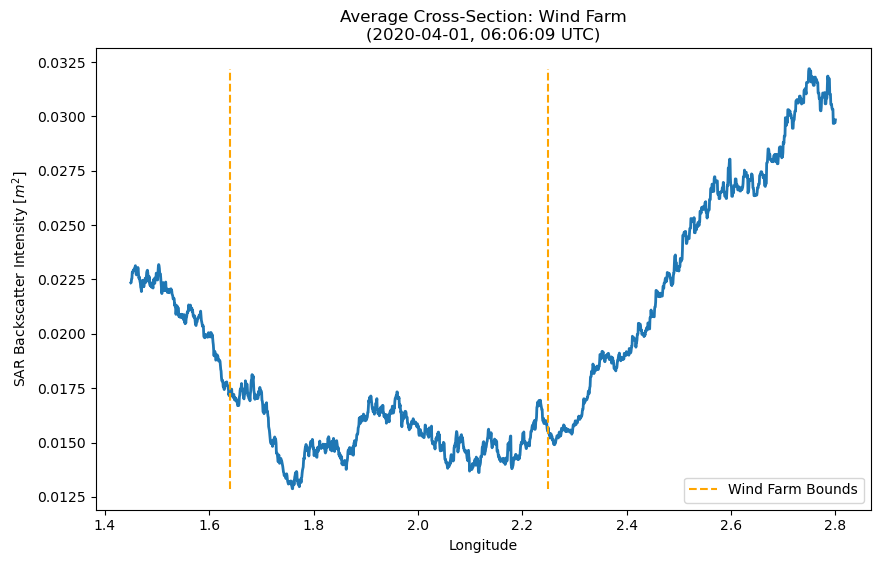

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

avg_cross_section = np.nanmean(sar_cross_sections, axis=0)
lons_cross_section = line_coords[0,:,0]

lineplot = ax.plot(
    lons_cross_section, avg_cross_section,
    linewidth=2,
)

ax.set_xlabel('Longitude')
ax.set_ylabel(f'SAR Backscatter Intensity {units}')

ax.set_title(f'Average Cross-Section: Wind Farm\n({this_time.strftime("%Y-%m-%d, %H:%M:%S")} UTC)')


ax.vlines(
    x=this_owf['lon_bounds'],
    ymin=np.nanmin(avg_cross_section),
    ymax=np.nanmax(avg_cross_section),
    linestyles='dashed',
    label='Wind Farm Bounds',
    color='orange'
)

ax.legend(loc='lower right')

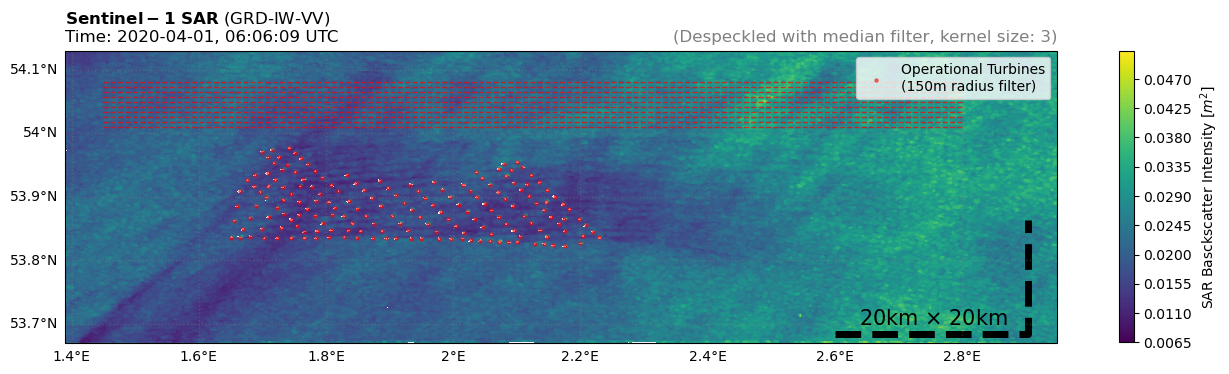

In [38]:
upshift = 0.17

points = np.array([
    [1.45, 53.91 + upshift],
    [2.8, 53.91 + upshift],
    [1.45, 53.84 + upshift],
    [2.8, 53.84 + upshift],
])


line_coords = line_sampler(points, num_lines=10, points_per_line=50)



'''init plot'''
fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection=ccrs.PlateCarree())



'''axes limits'''
ax.set_xlim(aoi_lon_bounds)
ax.set_ylim(aoi_lat_bounds)



'''layer 1: sar 2d data colored'''
# ax_sar_pcolormesh = ax.pcolormesh(
#     s1_dat['lon'], s1_dat['lat'], s1_dat['sar_db'][:-1,:-1],
#     shading='flat', # 'flat' means no interpolation
#     cmap='viridis',
#     alpha=0.8,
#     transform=ccrs.PlateCarree()
# )

# cbar = plt.colorbar(ax_sar_pcolormesh, shrink=0.42)
# cbar.set_label('SAR Backscatter $[dB]$')



ax_sar_contour = ax.contourf(
    s1_dat['lon'], s1_dat['lat'], s1_dat['sar_sm'],
    levels = 200,
    # vmax = -15,
    cmap = 'viridis',
    alpha = 1,
    transform = ccrs.PlateCarree()
)

cbar = plt.colorbar(ax_sar_contour, shrink=0.42)
# cbar = plt.colorbar(ax_sar_contour, shrink=0.7)


cbar.set_label(f'SAR Basckscatter Intensity {units}')






'''layer -2: turbine locs'''
ax_turbine_scatter = ax.scatter(
    x = this_turbine_coords[:,0],
    y = this_turbine_coords[:,1],
    # x = choice_turbine[0],
    # y = choice_turbine[1],
    transform = ccrs.PlateCarree(),
    # s = 1,
    s = 5,
    alpha=0.5,
    color = 'red', 
    label = f'Operational Turbines\n({radius_m}m radius filter)'
)

ax.legend(loc='upper right')





'''layer -1: coastlines'''
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='white', facecolor='white')) # white-out data on land masses
ax.coastlines(resolution='10m', linewidth=2, color='black') # draw coastlines






'''grid + ticks'''
ax_grid = ax.gridlines(
    transform=ccrs.PlateCarree(),
    draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle=':'
)

ax_grid.xformatter = LONGITUDE_FORMATTER
ax_grid.yformatter = LATITUDE_FORMATTER

ax_grid.top_labels = False
ax_grid.right_labels = False




'''scalebar'''

percent_spacing = 0.03
lon_bottom_right = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0]) * (1-percent_spacing)
lat_bottom_right = ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0]) * percent_spacing

km_scaling = 20
circle_1km = gd.Geodesic().circle(lon_bottom_right, lat_bottom_right, radius=km_scaling * 1.e3, n_samples=360)
lon_left = np.min(circle_1km[:,0])
lat_up = np.max(circle_1km[:,1])

x = np.array([lon_left, lon_bottom_right, lon_bottom_right])
y = np.array([lat_bottom_right, lat_bottom_right, lat_up])
plt.plot(
    x, y, 
    linewidth=5, 
    color='black', 
    linestyle='--',
    transform=ccrs.PlateCarree(),
)


percent_spacing = 0.05
lon_bottom_right = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0]) * (1-percent_spacing)
lat_bottom_right = ax.get_ylim()[0] + (ax.get_ylim()[1]-ax.get_ylim()[0]) * percent_spacing
ax.text(
    lon_bottom_right, lat_bottom_right,
    s= str(km_scaling) + r'km $\times$ ' + str(km_scaling) + 'km',
    fontsize=15,
    color='black',
    transform=ccrs.PlateCarree(),
    ha='right', va='bottom',
)



'''titles'''

title_1 = []
title_1.append(rf"$\bf{{Sentinel-1\ SAR}}$ (GRD-IW-{chosen_band})")
title_1.append(f"Time: {this_time.strftime('%Y-%m-%d, %H:%M:%S')} UTC")

title_1 = '\n'.join(title_1)
plt.title(title_1, loc='left') #, loc='left', fontsize=15)


if (apply_median_filter and kernel_size > 1):
    plt.title(f"(Despeckled with median filter, kernel size: {kernel_size})", loc='right', color='grey')


for line in line_coords:
    ax.plot(
        [line[0,0], line[-1,0]],
        [line[0,1], line[-1,1]],
        color='red',
        linestyle='--',
        linewidth=1,
        alpha=0.7,
        transform=ccrs.PlateCarree(),
    )



plt.show()

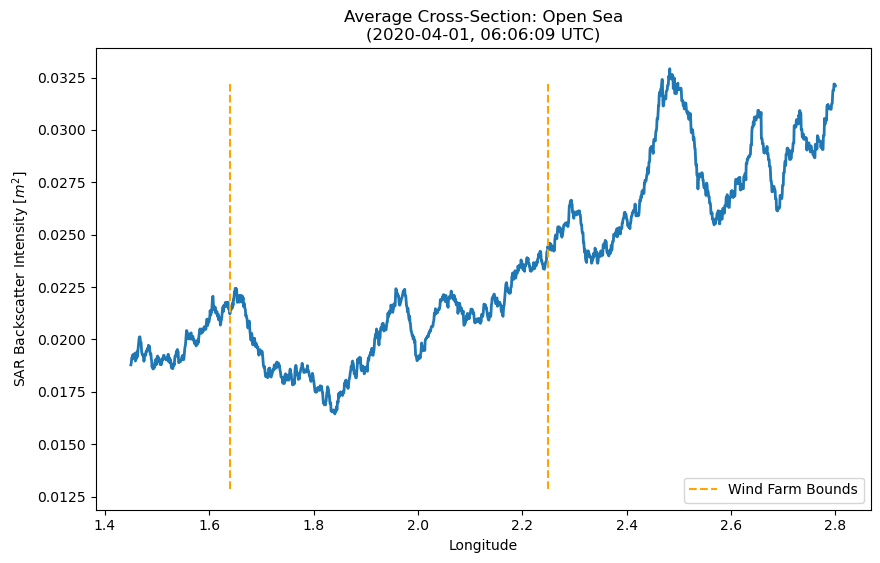

In [34]:
line_coords = line_sampler(points, num_lines=1000, points_per_line=2000)

reshaped_line_coords = line_coords.reshape(-1, 2).T
sar_cross_sections = optimized_find_nearest(reshaped_line_coords[0], reshaped_line_coords[1], s1_dat['lon'], s1_dat['lat'], s1_dat['sar_sm'])
sar_cross_sections = sar_cross_sections.reshape(line_coords.shape[:2])





fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

avg_cross_section_OPENSEA = np.nanmean(sar_cross_sections, axis=0)
lons_cross_section_OPENSEA = line_coords[0,:,0]

lineplot = ax.plot(
    lons_cross_section_OPENSEA, avg_cross_section_OPENSEA,
    linewidth=2,
)

ax.set_xlabel('Longitude')
ax.set_ylabel(f'SAR Backscatter Intensity {units}')

ax.set_title(f'Average Cross-Section: Open Sea\n({this_time.strftime("%Y-%m-%d, %H:%M:%S")} UTC)')


ax.vlines(
    x=this_owf['lon_bounds'],
    ymin=np.nanmin(avg_cross_section),
    ymax=np.nanmax(avg_cross_section),
    linestyles='dashed',
    label='Wind Farm Bounds',
    color='orange'
)

ax.legend(loc='lower right')

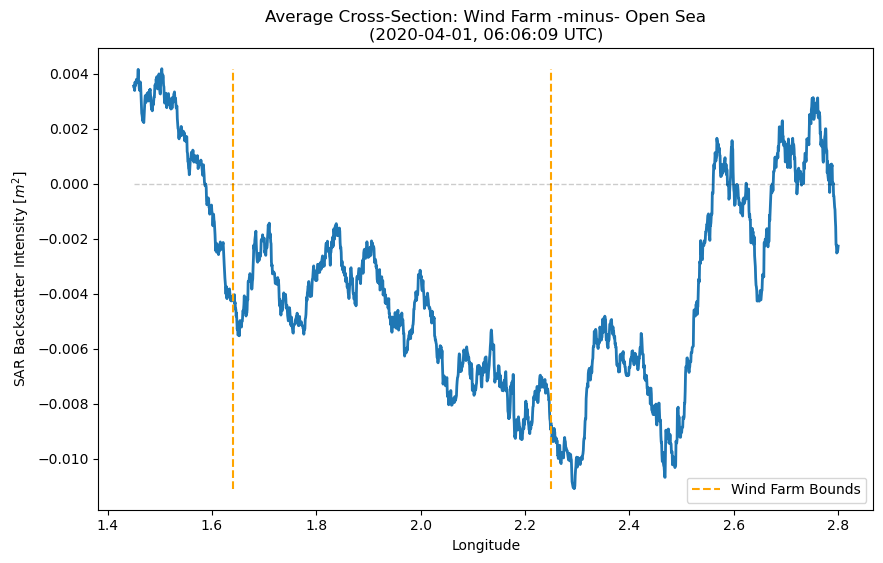

In [66]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

avg_cross_section_DETRENDED = avg_cross_section - avg_cross_section_OPENSEA

lineplot = ax.plot(
    lons_cross_section, avg_cross_section_DETRENDED,
    linewidth=2,
)

ax.set_xlabel('Longitude')
ax.set_ylabel(f'SAR Backscatter Intensity {units}')

ax.set_title(f'Average Cross-Section: Wind Farm -minus- Open Sea\n({this_time.strftime("%Y-%m-%d, %H:%M:%S")} UTC)')


ax.vlines(
    x=this_owf['lon_bounds'],
    ymin=np.nanmin(avg_cross_section_DETRENDED),
    ymax=np.nanmax(avg_cross_section_DETRENDED),
    linestyles='dashed',
    label='Wind Farm Bounds',
    color='orange'
)

ax.hlines(
    y=0,
    xmin=np.nanmin(lons_cross_section),
    xmax=np.nanmax(lons_cross_section),
    linestyles='dashed',
    linewidth=1,
    color='black',
    alpha=0.2
)

ax.legend(loc='lower right')